# Project: Wrangle and analyze 'WeRateDogs' Twitter Data 

## Introduction:

> Below is the detailed process of wrangling and analyzing data from a popular twitter page.  The following code may be executed or simple summarized and is meant to be supplemented by these two additional documents:
> - `wrangle_report.pdf`
> - `act_report.pdf`

**Step 1:** First, all the necessary packages for wrangling, analyzing and visualizing data must be imported.

In [1]:
#import necessary packages
import numpy as np
import pandas as pd
import requests
import os
import json
import tweepy
import matplotlib.pyplot as plt
import seaborn as sns

#display visualizations in this notebook
%matplotlib inline

#format all visualization backgrounds with seaborn
sns.set()


 ## Part I: Gather Data

**Step 1:** The `twitter_archive_enhanced.csv` file onhand is read into a pandas dataframe.

In [2]:
#read the .csv file as a pandas dataframe and assign it to the variable twdf
twdf = pd.read_csv('twitter-archive-enhanced.csv')
#preview first few lines
twdf.head()


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


**Step 2:** Now, the Udacity hosted file: `image_predictions.tsv` is downloaded via the requests library and assigned to a pandas dataframe.

In [3]:
#open image_predictions.tsv and write the response to the `image_predictions.tsv` file
def download_preds():
    '''
    First this assigns file location to url variable.
    Then th requests library is used to download url and assign to response variable.
    Finally, with the file open, the response is written to the `image_predictions.tsv` file.
    '''
    url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
    response = requests.get(url)
    with open('image_predictions.tsv', 'wb') as file:
        file.write(response.content)

#only execute function if the file does not already exist
if os.path.isfile('image_predictions.tsv'):
    print('already completed')
else:
    download_preds()

already completed


In [4]:
#read the predictions file to a pandas dataframe and assign to pred_df variable
pred_df = pd.read_csv('image_predictions.tsv', sep='\t')
pred_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


**Step 3:** Use the Tweepy library to download each tweets JSON data into the single text file: `tweet_json.txt`. Then read the information on each line of the file into a pandas dataframe.

In [5]:
#assign twitter developer keys, authorze them, then assign twitter API to the api object variable
consumer_key = 'YOUR CONSUMER KEY'
consumer_secret = 'YOUR CONSUMER SECRET'
access_token = 'YOUR ACCESS TOKEN'
access_secret = 'YOUR ACCESS SECRET'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [6]:
#save all tweets json data to a single text document
def save_tweet_jsons():
    '''
    -writes each tweets JSON data as a one_line string to 'tweet_json.txt' queried by each tweet_id in the dataframe: twdf
    -also has counter to completion
    -try block is used to continue in case there is no data to write
    '''
    count = twdf.tweet_id.count()
    with open('tweet_json.txt', 'w') as file:
        for tweet_id in twdf['tweet_id']:
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')._json
                json.dump(tweet, file)
                file.write('\n')
                count -= 1 
                print(count)
            except tweepy.error.TweepError:
                count -= 1 
                print('TweepError', count)
                continue

#only execute function if file does not already exist
if os.path.isfile('tweet_json.txt'):
    print('already completed')
else:
    save_tweet_jsons()

already completed


In [7]:
#read each tweets JSON data as a line from `tweet_json.txt` and append their desired data to a list.
df_list =[]
index=0
with open('tweet_json.txt') as full_json_file:
    for line in full_json_file.readlines():
        data = json.loads(line)
        tweet_id = data['id']
        retweet_count = data['retweet_count']
        favorite_count = data['favorite_count']
        df_list.append({'tweet_id': tweet_id,
                        'retweet_count': retweet_count,
                        'favorite_count': favorite_count})
        

    

In [8]:
#converts the list with json data to a pandas dataframe assigned to the variable: json_df
json_df = pd.DataFrame(df_list)
json_df.head()

,favorite_count,retweet_count,tweet_id
0,37524,8188,892420643555336193
1,32256,6057,892177421306343426
2,24300,4005,891815181378084864
3,40872,8330,891689557279858688
4,39065,9033,891327558926688256


## Part II: Assess Data

**Step 0.5** Visual Assessment of Data

In [9]:
#Display twdf dataframe
twdf

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [10]:
#Display pred_df dataframe
pred_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [11]:
#Display json_df dataframe
json_df

,favorite_count,retweet_count,tweet_id
0,37524,8188,892420643555336193
1,32256,6057,892177421306343426
2,24300,4005,891815181378084864
3,40872,8330,891689557279858688
4,39065,9033,891327558926688256
5,19641,2997,891087950875897856
6,11476,1984,890971913173991426
7,63307,18182,890729181411237888
8,27014,4120,890609185150312448
9,30942,7108,890240255349198849


**Step 1:** First, a random sample of five observations are displayed for each of the three dataframes in order to become familiar with the data.

In [12]:
#inspect five lines of the twdf dataframe
twdf.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a truly beautiful English Wilson Staff...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758...,10,10,a,None,None,None,None
1046,743545585370791937,NaN,NaN,2016-06-16 20:47:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Bentley and Millie. They do every...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/743545585...,11,10,Bentley,None,None,None,None
1231,713177543487135744,NaN,NaN,2016-03-25 01:35:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lance. Lance doesn't give a shit. 10/1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/713177543...,10,10,Lance,None,None,None,None
1208,715704790270025728,NaN,NaN,2016-04-01 00:58:13 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Bentley. He gives kisses back. 11/10 p...,NaN,NaN,NaN,https://vine.co/v/ijAlDnuOD0l,11,10,Bentley,None,None,None,None
815,771004394259247104,NaN,NaN,2016-08-31 15:19:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @katieornah: @dog_rates learning a lot at c...,7.710021e+17,1.732729e+09,2016-08-31 15:10:07 +0000,https://twitter.com/katieornah/status/77100213...,12,10,None,None,None,pupper,None


In [13]:
#inspect five lines of the pred_df dataframe
pred_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
288,671159727754231808,https://pbs.twimg.com/media/CVBwNjVWwAAlUFQ.jpg,1,pitcher,0.117446,False,sunglasses,0.062487,False,mask,0.059517,False
1045,712809025985978368,https://pbs.twimg.com/media/CeRoBaxWEAABi0X.jpg,1,Labrador_retriever,0.868671,True,carton,0.095095,False,pug,0.007651,True
917,701570477911896070,https://pbs.twimg.com/media/Cbx6nz1WIAA0QSW.jpg,1,Yorkshire_terrier,0.907990,True,silky_terrier,0.076883,True,Australian_terrier,0.008473,True
1296,752173152931807232,https://pbs.twimg.com/media/CnBBfNuWcAAkOgO.jpg,1,Labrador_retriever,0.527659,True,German_shepherd,0.174765,True,Chihuahua,0.045525,True
396,673656262056419329,https://pbs.twimg.com/media/CVlOy3pW4AQ9H1K.jpg,1,bull_mastiff,0.700625,True,Rhodesian_ridgeback,0.094698,True,Brabancon_griffon,0.057559,True


In [14]:
#inspect five lines of the json_df dataframe
json_df.sample(5)

,favorite_count,retweet_count,tweet_id
469,10906,4096,815390420867969024
2212,299,105,668226093875376128
678,28091,8607,786963064373534720
1666,1831,473,681679526984871937
631,6533,1837,793150605191548928


**Step 2:** One thing that catches the eye is inconsistent capitalization of dognames in the collumn: `pred_df['p1']`, so the fifteen most common values are inspected below.  Interestingly, the fifteenth is not even a dog.

In [15]:
#inspect the fifteen most common dog prediction names in pred_df
pred_df.p1.value_counts().head(15)

golden_retriever            150
Labrador_retriever          100
Pembroke                     89
Chihuahua                    83
pug                          57
chow                         44
Samoyed                      43
toy_poodle                   39
Pomeranian                   38
malamute                     30
cocker_spaniel               30
French_bulldog               26
Chesapeake_Bay_retriever     23
miniature_pinscher           23
seat_belt                    22
Name: p1, dtype: int64

**Step 3:** To better understand the quality of data, the pandas `.info()` method is used on all three dataframes.  From this, various issues of wrong datatypes and missing values are revealed.

In [16]:
#view shape, collumn names and datatypes of twdf dataframe
twdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [17]:
#view shape, collumn names and datatypes of pred_df dataframe
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [18]:
#view shape, collumn names and datatypes of json_df dataframe
json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 3 columns):
favorite_count    2337 non-null int64
retweet_count     2337 non-null int64
tweet_id          2337 non-null int64
dtypes: int64(3)
memory usage: 54.9 KB


**Step 4:** since there are not many rows with data in the `twdf['retweeted_status_id']` collumn, a sample of five of these rows are queried. It appears that these are retweets. 

In [19]:
#sample retreat observations in the twdf dataframe for closer inspection
twdf[~twdf['retweeted_status_id'].isnull()].sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
506,812747805718642688,NaN,NaN,2016-12-24 19:52:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Sammy. At first I was like...,6.800555e+17,4.196984e+09,2015-12-24 16:00:30 +0000,https://twitter.com/dog_rates/status/680055455...,10,10,Sammy,None,None,None,None
535,807059379405148160,NaN,NaN,2016-12-09 03:08:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Cali. She arrived preas...,7.829691e+17,4.196984e+09,2016-10-03 15:42:44 +0000,https://twitter.com/dog_rates/status/782969140...,12,10,Cali,None,None,None,None
435,820446719150292993,NaN,NaN,2017-01-15 01:45:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Peaches. She's the ulti...,8.001414e+17,4.196984e+09,2016-11-20 00:59:15 +0000,https://twitter.com/dog_rates/status/800141422...,13,10,Peaches,None,None,None,None
309,835536468978302976,NaN,NaN,2017-02-25 17:06:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Lola. Her hobbies include ...,8.352641e+17,4.196984e+09,2017-02-24 23:04:14 +0000,https://www.gofundme.com/lolas-life-saving-sur...,12,10,Lola,None,None,None,None
319,834477809192075265,NaN,NaN,2017-02-22 18:59:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Leo. He was a skater pu...,8.295020e+17,4.196984e+09,2017-02-09 01:27:41 +0000,https://twitter.com/dog_rates/status/829501995...,12,10,Leo,None,None,None,None


**Step 5:** Since the number of rows in the three dataframes are not the same, it might help to check and see how many of the tweet_id's do not match accross dataframes for tidiness reasons.  This operation is performed below.

In [20]:
#create a list of tweet_id's in pred_df in order to count how many are not in the twdf dataframe

pred_ids = list(pred_df['tweet_id'])
count = 0
for tweet_id in twdf['tweet_id']:
    if tweet_id not in pred_ids:
        count += 1
count   

281

In [21]:
#then count how many json_df tweet_id's are not in the pred_df dataframe

count = 0
for tweet_id in json_df['tweet_id']:
    if tweet_id not in pred_ids:
        count += 1
count

272

**Step 6:**  Finally, the quality and tidiness issues are summarized as follows.

### Quality Issues:

- tweet_id is the wrong data type in all three tables
- `twdf` timestamps are wrong data type
- dog names are 'None' strings when they should be null in the `twdf` table
- some of the `twdf` observations are retweets
- missing `twdf['expanded_url']` data
- some of the `pred_df` observations are probably not dogs
- dog types in the p1, p2 and p3 collumns of the `pred_df` table are inconsistently capitalized
- since some tweet_ids in `twdf` and `json_df` are not in the pred_df, there is missing image data

### Tidiness Issues:

- the four 'doggo', 'floofer', 'pupper' and 'puppo' collumns represent one categorical variable
- some of the `json_df` tweet_id's have no prediction data
- there is no prediction info for some of the tweet_ids
- all data should be in a single table without the 'in_reply_to_status_id',	'in_reply_to_user_id', 'retweeted_status_id', and 'retweeted_status_user_id' collumns
- p2 and p3 info from pred_df does not need to be included since it is not relevent to the desired statistical analysis and visualization

## Part III: Clean Data

**Step 1:** Before cleaning, a copy of the `twdf` dataframe is created as `master_df` to initiate the process.

In [22]:
#create a copy of twdf for cleaning as the master_df
#then copy pred_df and json_df for cleaning
master_df = twdf.copy()
json_clean = json_df.copy()
pred_clean = pred_df.copy()
master_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


**Step 2:** Address the following datatype issues:

- tweet_id is the wrong data type in all three tables
- `twdf` timestamps are wrong data type

##### Definition:
- use the pandas `.astype()` method to convert each table's `tweet_id` collumn to string datatype
- use to pandas `to_datetime()` method to convert the timestamps in `master_df` to datetime

##### Code:

In [23]:
#set the tweet_id for each table equal to itself as a string to save changes inplace
master_df['tweet_id'] = master_df['tweet_id'].astype('str')
json_clean['tweet_id'] = json_clean['tweet_id'].astype('str')
pred_clean['tweet_id'] = pred_clean['tweet_id'].astype('str')

In [24]:
#convert the timestamp collumn in master_df to datetime
master_df['timestamp'] = pd.to_datetime(master_df['timestamp'])


##### Test:

In [25]:
#check datatype of each change
print(master_df['timestamp'].dtypes)
print(master_df['tweet_id'].dtypes)
print(json_clean['tweet_id'].dtypes)
print(pred_clean['tweet_id'].dtypes)

datetime64[ns, UTC]
object
object
object


**Step 3:** Address the tidiness and cleanliness issue in the `doggo`, `floofer`, `pupper`, and `puppo` collumns.  For convenience, the remaining two quality issues in `master_df` are addressed as well.

- dog names are 'None' strings when they should be null in the `twdf` table
- the four 'doggo', 'floofer', 'pupper' and 'puppo' collumns represent one categorical variable
- some of the `twdf` observations are retweets


##### Definition:

- replace 'None' with '' for all for `doggo`, `floofer`, `pupper`, and `puppo` collumns
- concatenate `doggo`, `floofer`, `pupper`, and `puppo` collunns into a single collumn
- query the rows without a `retweeted_status_id` value and assign to the `master_df` variable


##### Code:

In [26]:
#replace all 'None' values in the four dog title categories with an empty string
for collumn in master_df.iloc[:,13:17]:
    master_df[collumn].replace({'None':''}, inplace=True)

#concatinate all strings in the four categories and create new 'dog_title' collumn
master_df['dog_title'] = master_df['doggo'] + master_df['floofer'] + master_df['pupper'] + master_df['puppo']

#replace empty string with NaN to represent no value
master_df['dog_title'].replace({'': np.nan}, inplace=True)

In [27]:
#Drop the four unnecessary collumns
master_df.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

In [28]:
#query all rows that do not have a retweeted_status_id and assign as master_df
master_df = master_df.query("retweeted_status_id != retweeted_status_id")

##### Test:

In [29]:
#check the collumns for the four drops and single addition
master_df.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_title
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN


In [30]:
#check the 'dog_title' values
master_df.dog_title.value_counts()

pupper          224
doggo            75
puppo            24
doggopupper      10
floofer           9
doggopuppo        1
doggofloofer      1
Name: dog_title, dtype: int64

**Note:** Uh oh! It looks like the possibility of two dog titles was not taken into consideration.  In order to completely clean this data set, one would need to iterate and create a secondary dog title collumn.

In [31]:
#check for values in master_df.retweeted_status_id
master_df.retweeted_status_id.value_counts()

Series([], Name: retweeted_status_id, dtype: int64)

**Step 3.5** Iterative `dog_title` Cleaning

##### Defenition:
- The `dog_title` rows that start with 'doggo' but have another name appended must be extracted with the additional name saved in another collumn titled: `second_dog_title`

##### Code:

In [32]:
#extract any string that follows 'doggo' that is at least one character long from the 'dog_title' collumn
#then assign to the 'second_dog_title' collumn
master_df['second_dog_title'] = master_df['dog_title'].str.extract("^doggo(\w+)$")



In [33]:
#replace concatinated strings in dog_title collumn with doggo
master_df['dog_title'] = master_df['dog_title'].replace(['doggopupper',
                                                        'doggofloofer',
                                                        'doggopuppo'], 'doggo')

##### Test:

In [34]:
#count values in new collumn to confirm changes
master_df['second_dog_title'].value_counts()

pupper     10
floofer     1
puppo       1
Name: second_dog_title, dtype: int64

In [35]:
#count values in dog_title collumn to confirm change
master_df['dog_title'].value_counts()

pupper     224
doggo       87
puppo       24
floofer      9
Name: dog_title, dtype: int64

**Step 4:** Address the remaining two quality issues in the `pred_clean` table.

- some of the `pred_df` observations are probably not dogs
- dog types in the p1, p2 and p3 collumns of the `pred_df` table are inconsistently capitalized

##### Definition:

- drop the rows in `pred_clean` where the `p1_dog` collumn is False
- convert all rows in the `p1` collumn to lowercase. (`p2` and `p3` will be dropped eventually, so they are ignored)

##### Code:

In [36]:
#queries only the rows where the observation is probably a dog
pred_clean = pred_clean.query('p1_dog == True')

In [37]:
#converts all 'p1' strings to lowercase
pred_clean['p1'] = pred_clean.p1.str.lower()

##### Test:

In [38]:
#Ensures there are no observations that are probably not dogs in pred_clean
pred_clean.query('p1_dog != True')['p1_dog'].count() == 0

True

In [39]:
#sums the strings in 'p1' that contain capital letters
pred_clean['p1'].str.contains('[A-Z]', regex=True).sum()

0

**Step 5:** The remaining quality issue and four tidiness issues are addressed by joining tables.

- since some tweet_ids in `twdf` and `json_df` are not in the pred_df, there is missing image data
- missing `twdf['expanded_urls']` data
- some of the `json_df` tweet_id's have no prediction data
- there is no prediction info for some of the tweet_ids
- all data should be in a single table without the 'in_reply_to_status_id',	'in_reply_to_user_id', 'retweeted_status_id', and 'retweeted_status_user_id' collumns
- p2 and p3 info from pred_df does not need to be included since it is not relevent to the desired statistical analysis and visualization

##### Define:

The unnecessary collumns from the master_df must be removed and inner joins of all the desired collumns in all three tables will remove the remaining rows with missing data.  This is accomplished via the following three steps:

- First, drop the unnecessary collumns from `master_df` for this analysis:
 - `in_reply_to_status_id`
 - `in_reply_to_user_id`
 - `source`
 - `retweeted_status_id`
 - `retweeted_status_user_id`
 - `retweeted_status_timestamp`
 - `expanded_urls`
- Second, use the pandas merge method to inner join the following desired collumns from the `pred_clean` table:
 - `jpg_url`
 - `img_num`
 - `p1`
 - `p1_conf`
 - `p1_dog`
- Third, inner join the full json_clean table on `tweet_id`

##### Code:

In [40]:
#drop all unneccary collumns in master_df for this analysis
master_df.drop(['in_reply_to_status_id',
                'in_reply_to_user_id',
                'source',
                'retweeted_status_id',
                'retweeted_status_user_id',
                'retweeted_status_timestamp',
                'expanded_urls'], axis=1, inplace=True)

In [41]:
json_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 3 columns):
favorite_count    2337 non-null int64
retweet_count     2337 non-null int64
tweet_id          2337 non-null object
dtypes: int64(2), object(1)
memory usage: 54.9+ KB


In [42]:
#inner join the desired pred_clean collumns to the master_df on 'tweet_id' with the pandas.df.merge method
master_df = master_df.merge(pred_clean[['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog']], on='tweet_id')


In [43]:
#inner join the json_clean table to master_df with the pandas.df.merge method
master_df = master_df.merge(json_clean, on='tweet_id')

##### Test:

In [44]:
#check for deleted and merged collumns
master_df.head(0)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_title,second_dog_title,jpg_url,img_num,p1,p1_conf,p1_dog,favorite_count,retweet_count


In [45]:
#check for missing data, and resulting table shape
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1473 entries, 0 to 1472
Data columns (total 15 columns):
tweet_id              1473 non-null object
timestamp             1473 non-null datetime64[ns, UTC]
text                  1473 non-null object
rating_numerator      1473 non-null int64
rating_denominator    1473 non-null int64
name                  1473 non-null object
dog_title             228 non-null object
second_dog_title      10 non-null object
jpg_url               1473 non-null object
img_num               1473 non-null int64
p1                    1473 non-null object
p1_conf               1473 non-null float64
p1_dog                1473 non-null bool
favorite_count        1473 non-null int64
retweet_count         1473 non-null int64
dtypes: bool(1), datetime64[ns, UTC](1), float64(1), int64(5), object(7)
memory usage: 174.1+ KB


## Part IV: Store, Analyze and Visualize Data

**Step 1:** Store the `master_df` dataframe as `twitter_archive_master.csv`:

In [46]:
#save master_df to *.csv file only if it does not already exist
if os.path.isfile('twitter_archive_master.csv'):
    print('already exists')
else:
    master_df.to_csv('twitter_archive_master.csv')


already exists


**Step 2:** The following three questions are addressed with statistical analysis:

1. Is there any significant difference between the top ten dog types and thier favorite counts?
2. Is there any correlation between dog rating and the occorance of a dog title?
3. Do the `favorite_count` and `retweet_count` of posts change over time?

##### Question 1:
Is there any significant difference between the top ten dog types and thier average favorite counts?

In [47]:
#creates a list of the top ten predicted dog types in master_df
top_10_dogs = list(master_df['p1'].value_counts().head(10).index)

#groups each dog type in master_df by predicted dog type and assigns to the variable: mean_favorites
mean_favorites = master_df.groupby('p1')['favorite_count'].mean()

#filters the mean_favorites series by the top ten dog types and assigns to the variable: top_10_favorites
top_10_favorites = mean_favorites[mean_favorites.index.isin(top_10_dogs)]

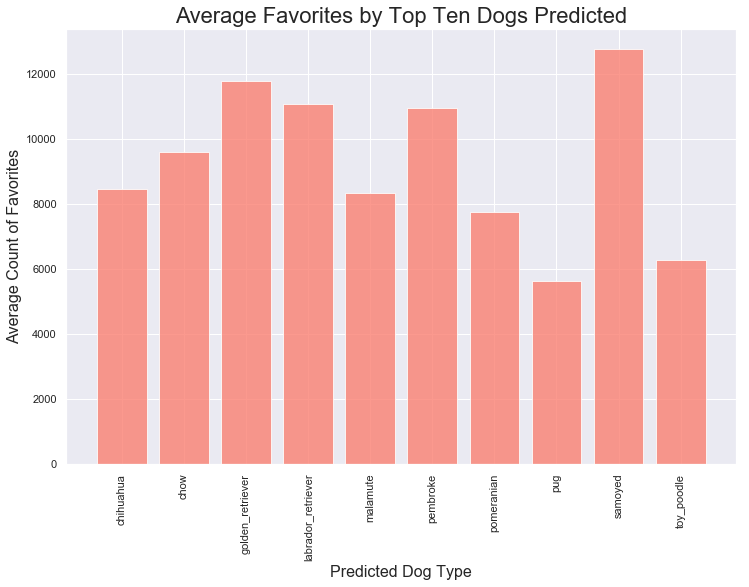

In [48]:
#format image size
plt.figure(figsize=(12, 8))

#plot a bar chart of average likes for each of the top ten dogs tweeted.
plt.bar(top_10_favorites.index, top_10_favorites.values, color='salmon',alpha=.8)
plt.xticks(top_10_favorites.index, rotation='vertical')
plt.title('Average Favorites by Top Ten Dogs Predicted', fontsize=22)
plt.xlabel('Predicted Dog Type', fontsize=16)
plt.ylabel('Average Count of Favorites', fontsize=16)

#save as .png file if it doesn't already exist
if os.path.isfile('averages_of_topdogs.png'):
    print('already_saved')
else:
    plt.savefig('averages_of_topdogs.png')

##### Summary of result:

Interestingly, the pug is the least commonly favorited with strikingly less than half the average likes than the samoyed.  There appears to be some significant difference in favorites between the top ten most common dog breeds on the WeRateDogs page.

##### Question 2: 
Is there any correlation between dog rating and the first occorance of a dog title? (only ratings with denominator of 10 are considered)

In [49]:
#query the average ratings with the denominator of 10 for specific dog titles. 
master_df.query('rating_denominator == 10').groupby('dog_title')['rating_numerator'].mean()

dog_title
doggo      11.896552
floofer    12.000000
pupper     11.062500
puppo      12.000000
Name: rating_numerator, dtype: float64

In [50]:
#query the average rating with a denominator of 10 for observations with no 'dog_title'
no_title = master_df.query('rating_denominator == 10 and dog_title != dog_title')['rating_numerator'].mean()
print('average rating for titleless dogs:', no_title)

average rating for titleless dogs: 10.91219512195122


##### Summary of result:
The average rating appears to be between 11 and 13 out of 10 regardless of the dogs professional title as 'doggo', 'floofer', 'pupper', or 'puppo'.  Additionally this is not significantly higher than ratings for dogs with no title, for whom on average, ratings are nearly 11/10.

##### Question 3:
Do the favorite_count and retweet_count of posts change over time?

In [51]:
#
master_df.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,dog_title,second_dog_title,jpg_url,img_num,p1,p1_conf,p1_dog,favorite_count,retweet_count
0,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,chihuahua,0.323581,True,32256,6057
1,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,chihuahua,0.716012,True,24300,4005
2,891327558926688256,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,12,10,Franklin,NaN,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,39065,9033
3,891087950875897856,2017-07-29 00:08:17+00:00,Here we have a majestic great white breaching ...,13,10,None,NaN,NaN,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,chesapeake_bay_retriever,0.425595,True,19641,2997
4,890971913173991426,2017-07-28 16:27:12+00:00,Meet Jax. He enjoys ice cream so much he gets ...,13,10,Jax,NaN,NaN,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,appenzeller,0.341703,True,11476,1984


In [52]:
#group the average favorite_count by month and save to the variable: favs_bymonth
favs_bymonth = master_df.groupby(pd.Grouper(key='timestamp', freq='M'))['favorite_count'].mean()

#group the average retweet_count by month and save to the variable: retweets_bymonth
retweets_bymonth = master_df.groupby(pd.Grouper(key='timestamp', freq='M'))['retweet_count'].mean()

C:\Users\jeffr\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


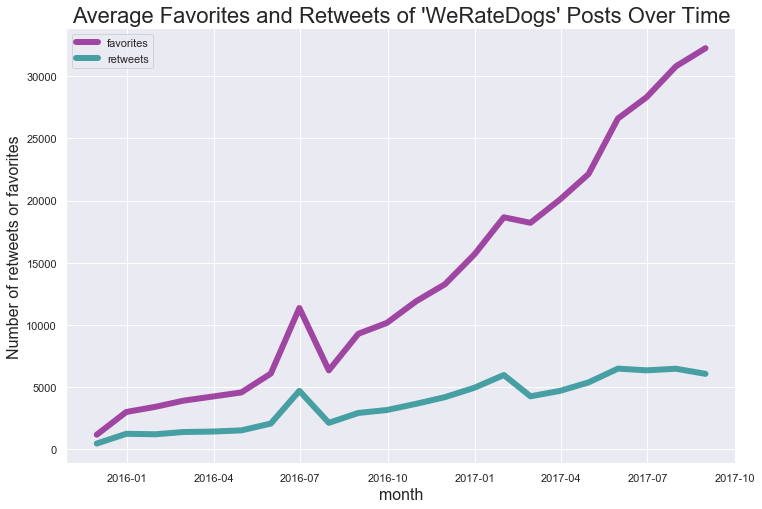

In [53]:
#format image size
plt.figure(figsize=(12, 8))

#plot the average retweets and favorites grouped by month into a line chart
plt.plot(favs_bymonth.index, favs_bymonth.values, color='purple', label='favorites', linewidth=6, alpha =.7)
plt.plot(retweets_bymonth.index, retweets_bymonth.values, color='teal', label='retweets', linewidth=6, alpha =.7)

#format chart with labels and legend
plt.title("Average Favorites and Retweets of 'WeRateDogs' Posts Over Time", fontsize=22)
plt.xlabel('month', fontsize=16)
plt.ylabel('Number of retweets or favorites', fontsize=16)
plt.legend()

#save as .png file if it does not already exist
if os.path.isfile('averages_by_month.png'):
    print('already_saved')
else:
    plt.savefig('averages_by_month.png')

##### Summary of result:
As illustrated by the above line chart, Average favorites and retweets by month for the WeRateDogs page have increased at a steady rate over time with a notable spike near July, 2016.  Also of note is how closely correlated retweets and favorites appear to be with consistantly more favorites than retweets.

## Part V: Report

*Please see the included documents: `wrangle_report.pdf` and `act_report.pdf` for conclusions of this analysis.*